# ML Model Evaluation


In [1]:
import matplotlib.pyplot as plt, pandas as pd
from adni_utils import df_of_csv, OUTPUT_DIR
from modelling_evaluation_utils import *
from pickle import load
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

### Load The Saved Ensemble Model


In [2]:
LABEL_COL = "DX"
RANDOM_STATE = 42
ENSEMBLE_DIR = f"{OUTPUT_DIR}/ENSEMBLE_MODEL.sav"
with open(ENSEMBLE_DIR, "rb") as f:
    ensemble_model = load(f)
ensemble_model

StackingClassifier(cv=5,
                   estimators=[('Logistic Regression',
                                LogisticRegression(C=0.1, random_state=42,
                                                   solver='newton-cg')),
                               ('Random Forest',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('Decision Tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=15,
                                                       max_features='log2',
                                                       random_state=42))],
                   final_estimator=LogisticRegression(C=0.1,
                                                      solver='newton-cg'),
                   n_jobs=-1)

### Load The Pre-Processed Datasets


In [3]:
load_dataset = lambda filename: df_of_csv(f"{filename}_DATASET", input_dir=False)
base = load_dataset("BASE")
base_with_csf = load_dataset("BASE_WITH_CSF")
base_with_plasma = load_dataset("BASE_WITH_PLASMA")
full = load_dataset("FULL")

### Evaluating The Base Dataset


In [4]:
base_model_evaluation = evaluate_ensemble_model(ensemble_model, base, LABEL_COL)
pretty_print_ensemble_model_results("BASE", base_model_evaluation)

Results for the BASE dataset using the ensemble model -
1. Accuracy:	 0.82 ± 0.01
2. F1-Score:	 0.54 ± 0.04
3. Precision:	 0.75 ± 0.06
4. Recall:	 0.42 ± 0.04
5. AUC:		 0.89 ± 0.01


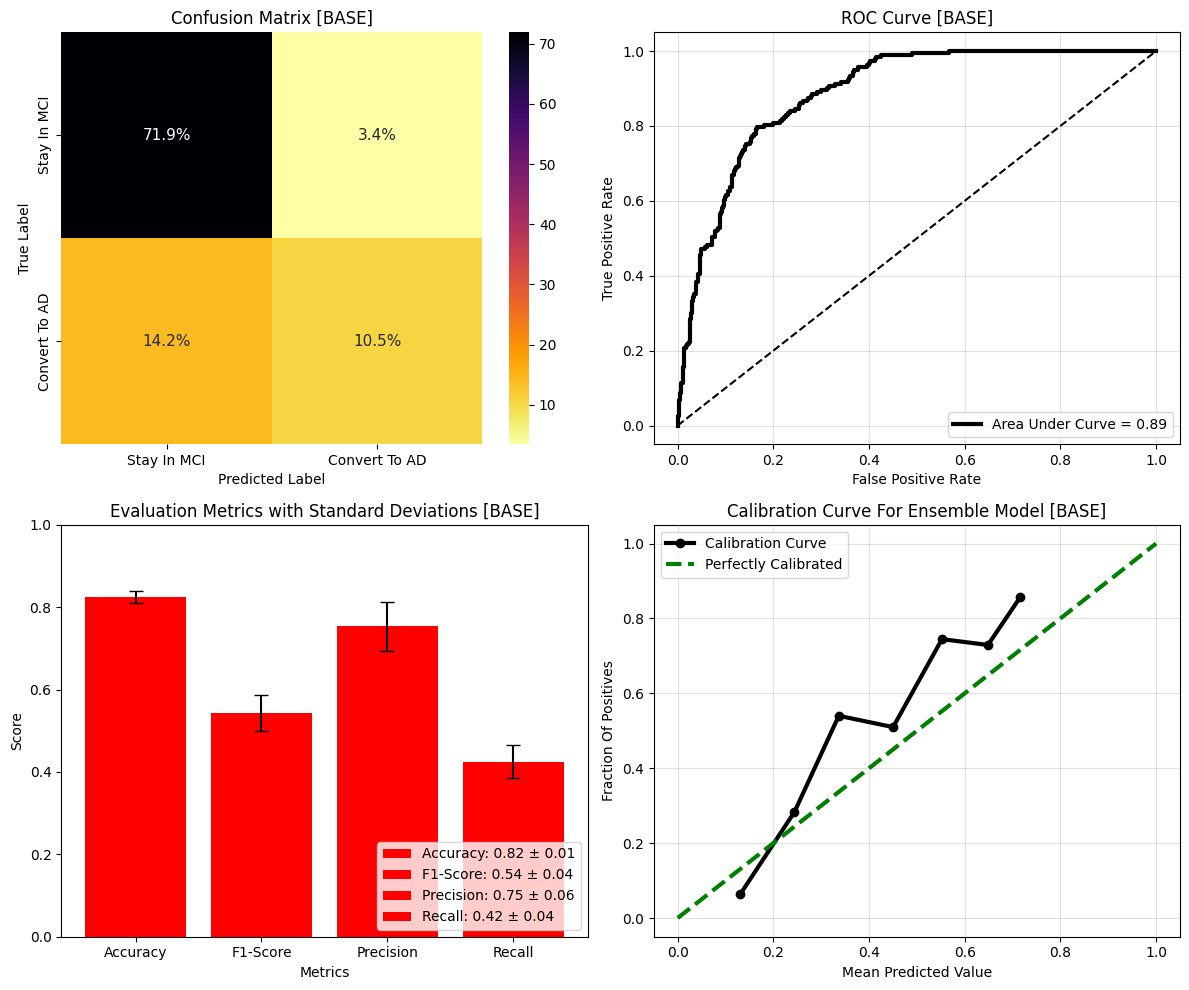

In [5]:
plot_ensemble_evaluation(base_model_evaluation, "BASE")

### Evaluating The Base With CSF Dataset


In [6]:
base_with_csf_model_evaluation = evaluate_ensemble_model(
    ensemble_model, base_with_csf, LABEL_COL
)
pretty_print_ensemble_model_results("BASE_WITH_CSF", base_with_csf_model_evaluation)

Results for the BASE_WITH_CSF dataset using the ensemble model -
1. Accuracy:	 0.82 ± 0.01
2. F1-Score:	 0.5 ± 0.03
3. Precision:	 0.77 ± 0.09
4. Recall:	 0.37 ± 0.03
5. AUC:		 0.88 ± 0.02


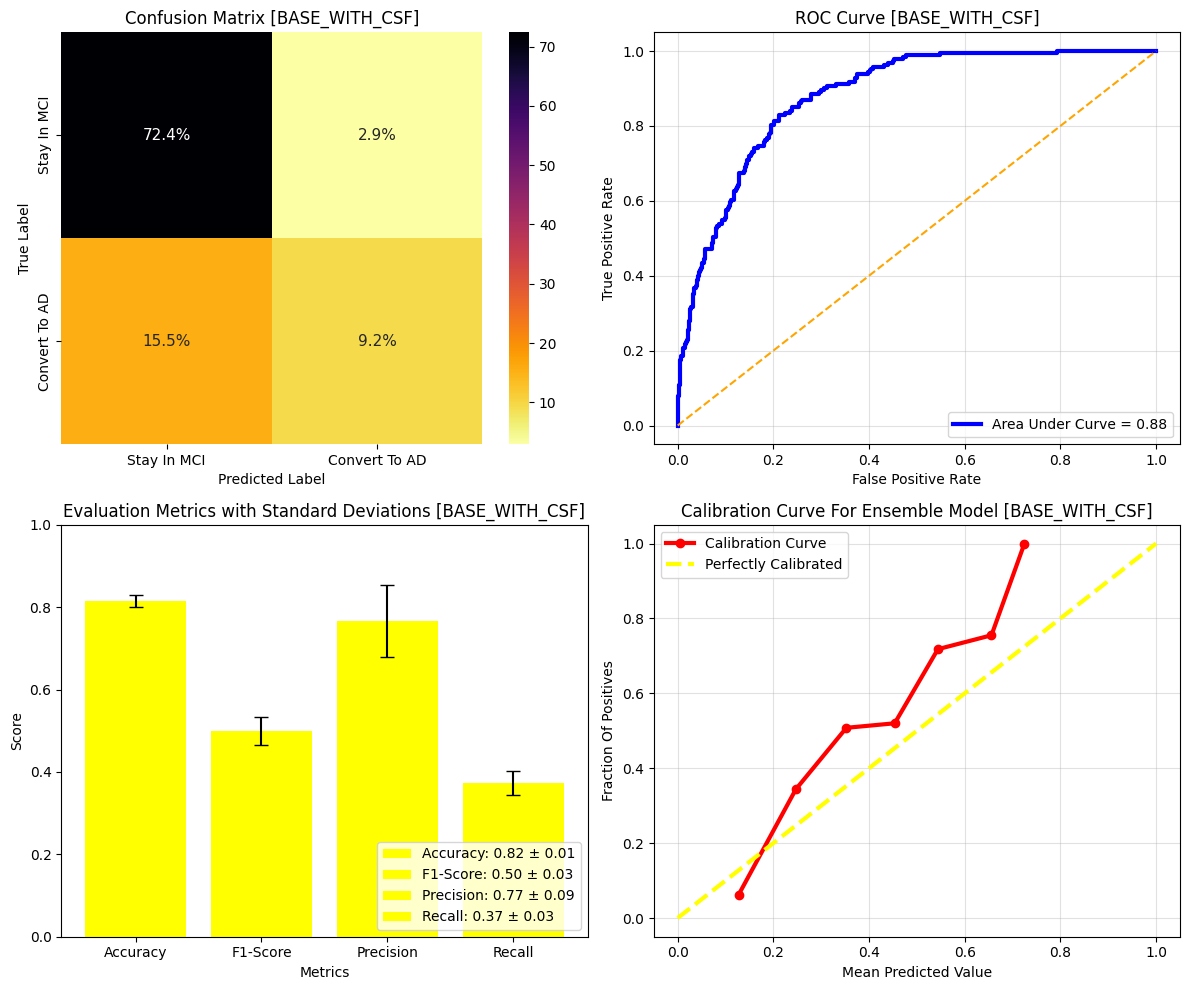

In [7]:
plot_ensemble_evaluation(base_with_csf_model_evaluation, "BASE_WITH_CSF")

### Evaluating The Base With Plasma Dataset


In [8]:
base_with_plasma_model_evaluation = evaluate_ensemble_model(
    ensemble_model, base_with_plasma, LABEL_COL
)
pretty_print_ensemble_model_results(
    "BASE_WITH_PLASMA", base_with_plasma_model_evaluation
)

Results for the BASE_WITH_PLASMA dataset using the ensemble model -
1. Accuracy:	 0.83 ± 0.02
2. F1-Score:	 0.56 ± 0.04
3. Precision:	 0.81 ± 0.08
4. Recall:	 0.44 ± 0.04
5. AUC:		 0.9 ± 0.02


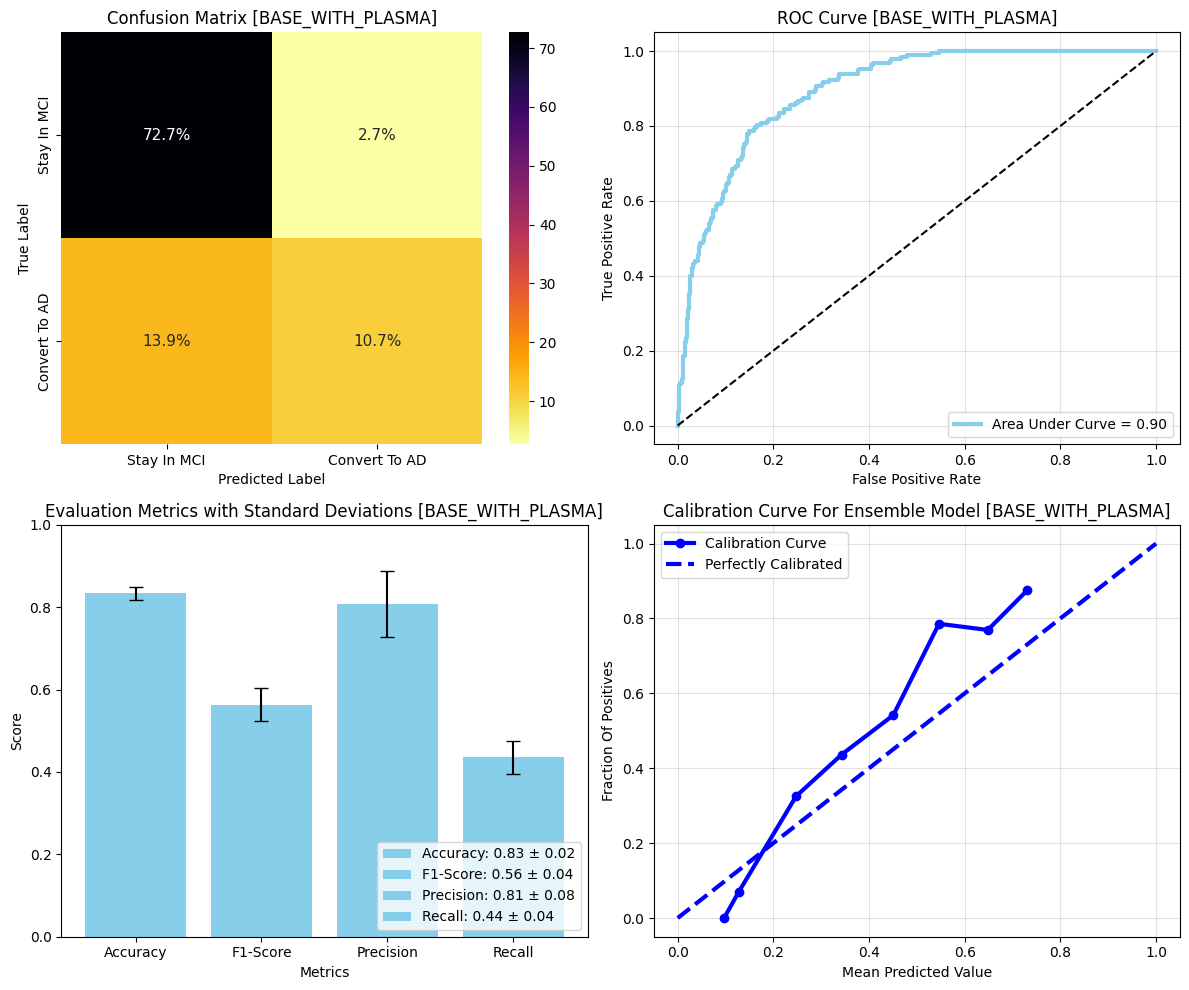

In [9]:
plot_ensemble_evaluation(base_with_plasma_model_evaluation, "BASE_WITH_PLASMA")

### Evaluating The Full Dataset


In [10]:
full_model_evaluation = evaluate_ensemble_model(ensemble_model, full, LABEL_COL)
pretty_print_ensemble_model_results("FULL", full_model_evaluation)

Results for the FULL dataset using the ensemble model -
1. Accuracy:	 0.83 ± 0.01
2. F1-Score:	 0.55 ± 0.04
3. Precision:	 0.81 ± 0.05
4. Recall:	 0.41 ± 0.05
5. AUC:		 0.89 ± 0.02


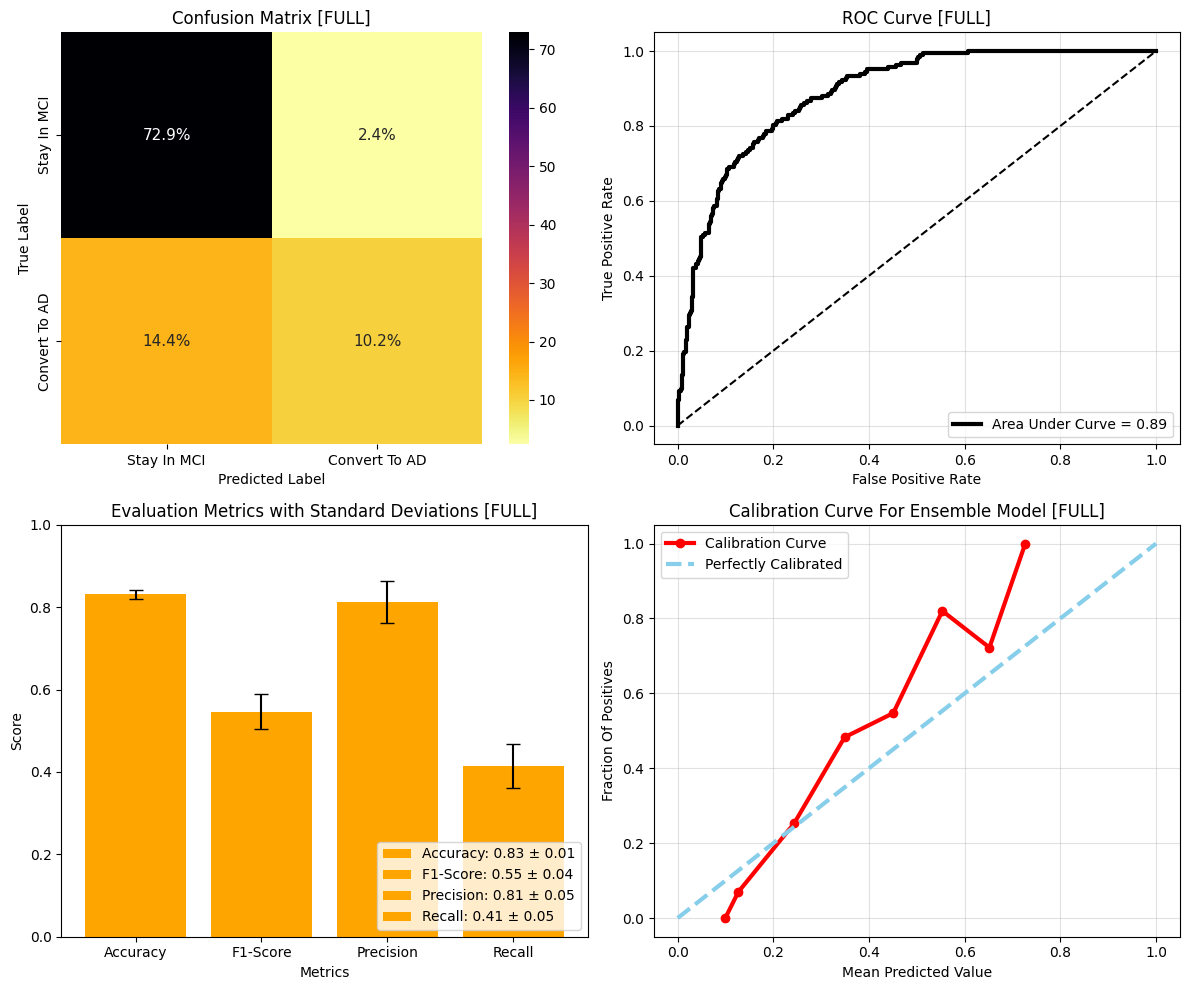

In [11]:
plot_ensemble_evaluation(full_model_evaluation, "FULL")

### Plot The Mutual Relationship Between Each Feature And `DX`


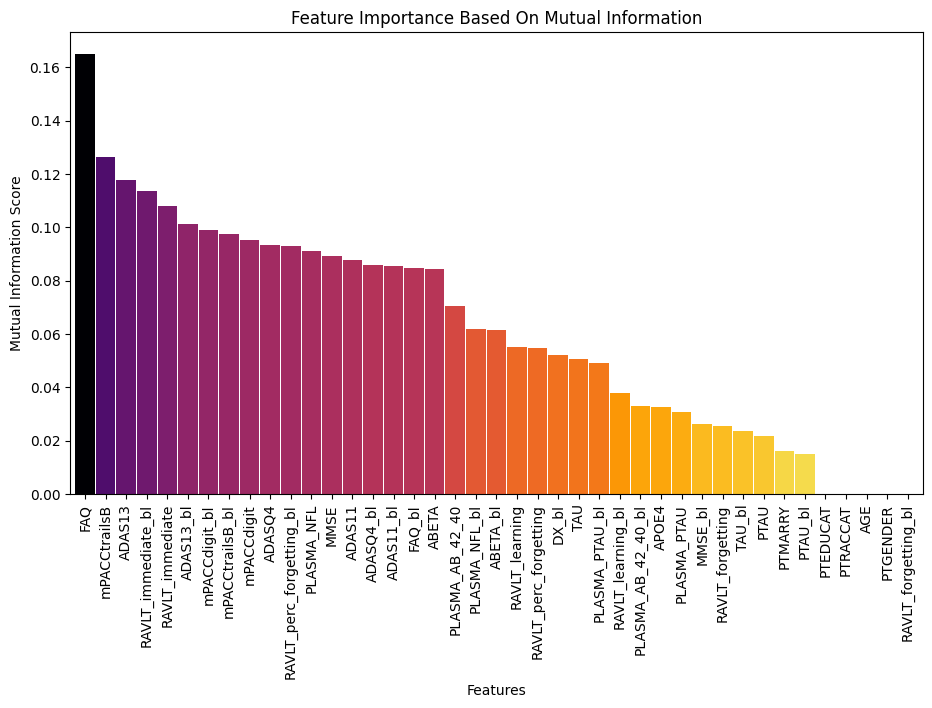

In [12]:
X = full.drop(columns=LABEL_COL)
Y = full[LABEL_COL]
mutual_info = mutual_info_classif(X, Y, random_state=RANDOM_STATE, n_jobs=-1)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = mutual_info.sort_values(ascending=False)
norm = plt.Normalize(mutual_info.min(), mutual_info.max())
cmap = plt.cm.inferno_r
mutual_info.plot.bar(
    ylabel="Mutual Information Score",
    xlabel="Features",
    figsize=(11, 6),
    color=(cmap(norm(mutual_info.values))),
    width=0.95,
    title="Feature Importance Based On Mutual Information",
)
plt.show()

### Plot The Permutation Feature Importance


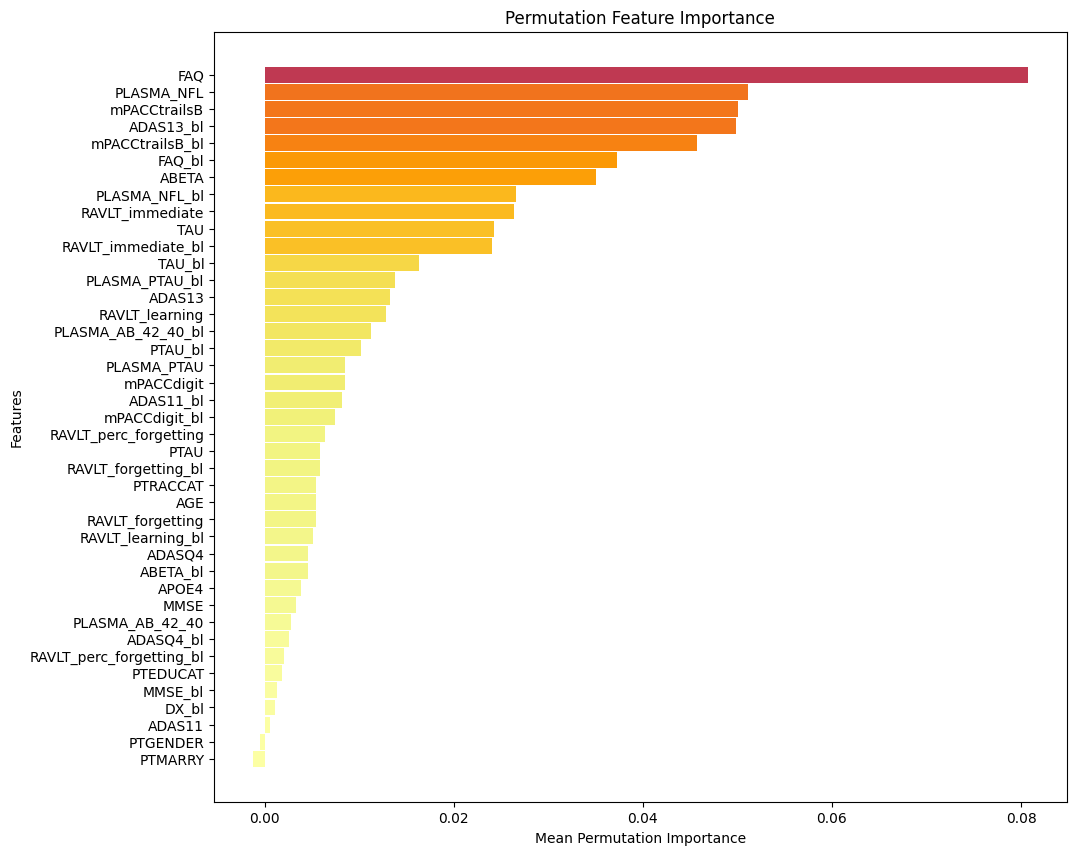

In [13]:
result = permutation_importance(
    ensemble_model, X, Y, scoring="accuracy", random_state=RANDOM_STATE, n_jobs=-1
)
perm_sorted_idx = result.importances_mean.argsort()
mean_importance = result.importances_mean[perm_sorted_idx]
plt.figure(figsize=(11, 10))
plt.barh(
    X.columns[perm_sorted_idx],
    mean_importance,
    color=(cmap(norm(mean_importance))),
    height=0.93,
)
plt.xlabel("Mean Permutation Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importance")
plt.show()